### Домашнее задание 3. Реализация простой Lambda-архитектуры хранилища.

В данной работе вам необходимо реализовать комплексный ETL-процесс. Ниже приложена его архитектурная схема.
Для решения необходимо использовать знакомые вам инструменты:
1. Spark DataFrame API/Spark Structured Streaming
2. Apache Iceberg on Hive - как хранилище
3. Apache Kafka - как шину данных
4. Apache Cassandra - как сервисную базу данных для слоя представления

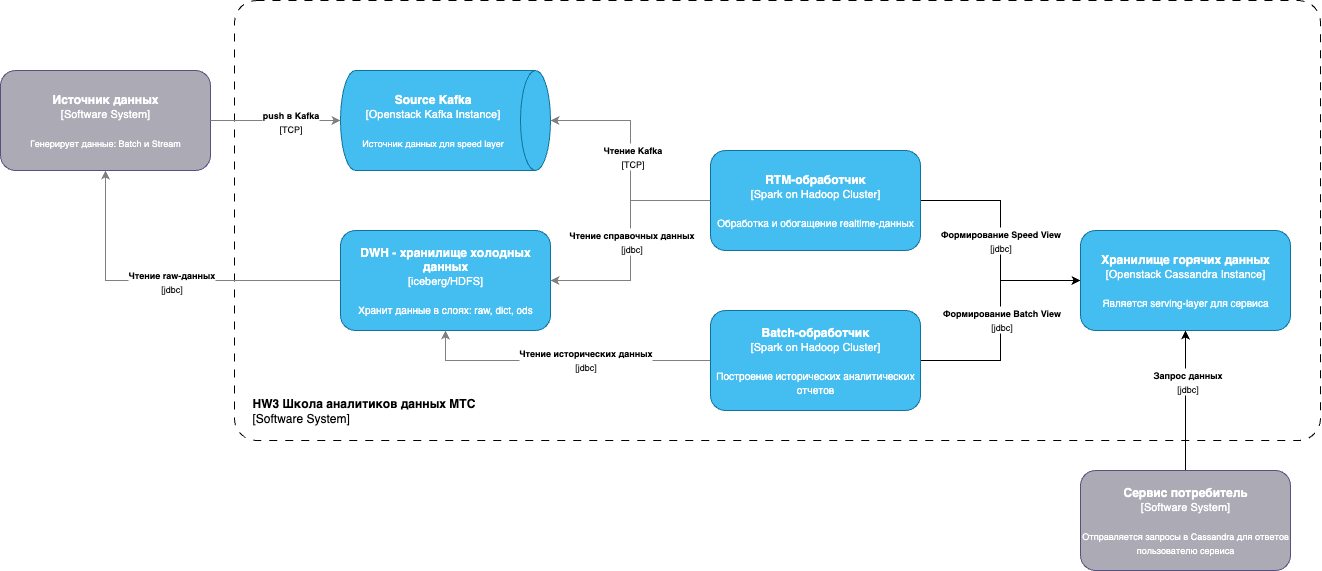

In [ ]:
from IPython.display import Image
Image(filename="/hw3/schema1.png")

#### Основные переменные и создание spark-сессии

In [1]:
CASSANDRA_URL = "dataops-hadoop-ext"
HIVE_METASTORE_URL = "thrift://dataops-hadoop-mn-1:9083"

JAVA_REQUIREMENTS = [
    "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.1",
    "org.apache.iceberg:iceberg-spark-runtime-3.3_2.12:1.6.1",
    "com.datastax.spark:spark-cassandra-connector_2.12:3.3.0",
]

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.window import Window

In [3]:
# параметры spark-сессии, которые необходимы для выполнения работы
# количество памяти и CPU определяете самостоятельно

# XXXX - поля для заполнения

spark = (
    SparkSession.builder.config("master", "yarn")
    .config("spark.sql.adaptive.enabled", False)
    .config("spark.sql.autoBroadcastJoinThreshold", -1)
    .config("spark.sql.shuffle.partitions", 16)
    .config("spark.sql.sources.bucketing.enabled", True)
    .config("spark.dynamicAllocation.enabled", False)
    .config("spark.executor.instances", "4")
    .config("spark.executor.cores", "4")
    .config("spark.driver.cores", "4")
    .config("spark.executor.memory", "650M")
    .config("spark.driver.memory", "650M")
    .config("spark.jars.packages", ",".join(JAVA_REQUIREMENTS))
    .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions")
    .config("spark.cassandra.connection.host", CASSANDRA_URL)
    .config("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    .config("spark.sql.catalog.ice_hdfs", "org.apache.iceberg.spark.SparkCatalog")
    .config("spark.sql.catalog.ice_hdfs.type", "hive")
    .config("spark.sql.catalog.ice_hdfs.uri", HIVE_METASTORE_URL)
    .config("spark.sql.catalog.ice_hdfs.warehouse", "hdfs://demo/warehouse")
    .appName("summary_hw_workshop-7-1")
    .getOrCreate()
)

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


:: loading settings :: url = jar:file:/usr/local/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/student_user20/.ivy2/cache
The jars for the packages stored in: /home/student_user20/.ivy2/jars
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
org.apache.iceberg#iceberg-spark-runtime-3.3_2.12 added as a dependency
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7fc9a998-b46f-4ff3-a700-55268e4d525e;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.3.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.3.1 in central
	found org.apache.kafka#kafka-clients;2.8.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.32 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.2 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.2 in central
	found commons-lo

2025-08-29 11:40:27 WARN  deploy.yarn.Client:73 - Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.
2025-08-29 11:40:31 WARN  deploy.yarn.Client:73 - Same path resource file:///home/student_user20/.ivy2/jars/org.apache.spark_spark-sql-kafka-0-10_2.12-3.3.1.jar added multiple times to distributed cache.
2025-08-29 11:40:31 WARN  deploy.yarn.Client:73 - Same path resource file:///home/student_user20/.ivy2/jars/org.apache.iceberg_iceberg-spark-runtime-3.3_2.12-1.6.1.jar added multiple times to distributed cache.
2025-08-29 11:40:31 WARN  deploy.yarn.Client:73 - Same path resource file:///home/student_user20/.ivy2/jars/com.datastax.spark_spark-cassandra-connector_2.12-3.3.0.jar added multiple times to distributed cache.
2025-08-29 11:40:31 WARN  deploy.yarn.Client:73 - Same path resource file:///home/student_user20/.ivy2/jars/org.apache.spark_spark-token-provider-kafka-0-10_2.12-3.3.1.jar added multiple times to distributed cache.


#### Примеры полезного кода

In [4]:
# подключение к Cassandra через python client

from cassandra.cluster import Cluster

cluster = Cluster([CASSANDRA_URL])
session = cluster.connect()

In [5]:
# подключение к топику Kafka через spark
topic = "tickets-topic"

kafka_stream = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "dataops-hadoop-ext:9092") \
    .option("subscribe", topic) \
    .option("startingOffsets", "latest") \
    .load()

### Что нужно сделать?

**1. Разведочный анализ (EDA) имеющихся данных**

Данные интеграции были настроены вашим коллегами из внешней для вас системы.

Необходимо рассмотреть данные в Iceberg-таблицах и Kafka. Описать какие проблемы с данными и/или их хранением существуют (если есть). Предложить возможные решения.


**2. Обработка near realtime потока данных tickets**

Для решения необходимо использовать Spark Structured Streaming для чтения Kafka (топик `tickets-topic`)

2.1. Настроить чтение данных с приведением стоимости проданных билетов к **базовой валюте**. Информацию о курсе можете взять из справочника **currency**

2.2. Подсчитать отставание данных:
- для сравнения использовать timestamp из топика Kafka
- отставание выражено в сутках
- исключить данные с отставанием от бизнес-даты больше 1 дня

2.3. Реализовать поточную трансформацию:
- выручка каждой авиакомпании за поступающий микробатч
- размер окна - 5 минут

**Важно**:
- все дробные данные должны округляться до сотых
- вывести результат команды `explain` в ячейку перед запуском (start) стриминга
- конечный результат должен поточно сохраняться в Cassandra (таблицу необходимо создать самостоятельно)
- результат (топ-10 строк) также обязательно выводится в ячейку с помощью запроса к БД (не через spark)

**3. Батчевая обработка сырых данных. Таблица flights**

3.1. В какие города летают авиакомпании?:
- Сформировать список городов
- Посчитать их количество

3.2. Построить отчет по авиапарку компаний за 2024-2025 год:
- для каждой компании подсчитайте количество самолетов каждой категории
- совокупную вместимость за год (максимальное количество, которое можно перевести за год)
- среднюю вместимость
- допущение: 1 рейс = 1 самолет (они не чередуются между рейсами)

3.3. Найти топ-5 авиакомпаний с наименьшим средним временем полета:
- реализовать описанную трансформацию
- учесть проведенный в п.1 EDA

3.4. Построить отчет по количеству перевезенных пассажиров за каждый квартал 2024 и 2025 года:
- сколько пасажиров авиакомпании могут перевезти за конкретный квартал в разрезе каждой компании
- посчитать изменение в процентах от квартала к кварталу (необходимо использовать оконные функции)
- проведите сортировку по количеству пассажиров по убыванияю

**(!)** Две из 4-х таблиц необходимы для реализации блока #4 (нужно понять какие)

**Важно**:
- все дробные данные должны округляться до сотых
- результаты сохранить в отдельные таблицы в схему `student_user{n}`, где `n` - номер юзера вашей УЗ.
- результат также обязательно выводится в ячейку командами `show(10, False)` и `explain`

**4. Реализация serving layer в Cassandra**

4.1. Спроектировать модель данных и создать таблицы для сохранения результатов из блоков 2 и 3. (всего должно быть 3 таблицы)

4.2. Реализовать репликацию данных в режиме батч из схемы ods Iceberg-таблицы в Cassandra (взять только нужные поля). Запускается 1 раз.

4.3. С помощью клиента cassandra-python выполнить запрос, отвечающий на вопрос (от потенциального сервиса): `Сможет ли конкретная авиакомпания отправить меня в конкретный город?`

4.4. Выполнить запрос, отвечающий на вопрос: `Сможет ли конкретная авиакомпания перевезти N пассажиров на основе данных за последний доступный отчётный квартальный период?`

4.5 Выполнить запрос, отвечающий на вопрос (на основе доступных данных): `Какая текущая выручка у конкретной компании за 2024 год?`

**Важно**:
- все таблицы нужно сохранить в keyspace с названием вида `hw_cassandra_ks_user{n}`, где `n` - номер юзера вашей УЗ.
- рассмотреть ограничения кейспейсов в БД cassandra, описать если учли
- результат п.4.3-4.5 должн быть выведен в ячейку

**Как повысить оценку?**: при необходимости/просьба дать текстовые пояснение - оформляете их в отдельных ячейках в виде Markdown разметки. Больше пояснений о принятых решениях - дополнительные баллы к оценке.


### Описание данных

Примечение: т.к. таблицы, хранящиеся в Hive, имеют iceberg формат, то они находятся в каталоге /ice_hdfs в HDFS. Также для обращения через Spark SQL нужно писать имя таблицы в формате `<iceberg_catalog_name>.hw.<table_name>`

**1. flights** содержит информацию об исторических рейсах различных авиакомпаний:
- number: номер рейса, первые 2 буквы - название авиакомпании
- departure: город отправления
- arrival: город прибытия
- departure_time: время отправления
- arrival_time: время прибытия
- manufacturer: производитель самолета
- model: модель самолета
- capacity: вместимость пассажиров
- luggage_allowed: разрешен ли багаж (значения "yes" или "no")
- meal_included: включено ли питание (значения "yes" или "no")

**Важно**: идентификатор авиакомпании - первые ДВЕ буквы из номера рейса


**2. currency** справочник, содержит информацию о курсах валют каждые 15 минут:
- timestamp: временная метка
- base_currency: базовая валюта
- target_currency: целевая валюта
- ratio: цена целевой валюты по отношению к базовой валюте
- partition_dt: партицирование таблицы по дате

**Важно**: базовая валюта - USD (американский доллар)

**3. tickets_topic** топик в Kafka, содержит информацию о покупках билетов в онлайн-системе:
- uuid: уникальный идентификатор совершенной операции
- number: номер рейса, на который был куплен билет
- price: цена билета
- currency_codes: валюта, за которую был куплен билет
- transaction_timestamp: время совершения операции

Схема взаимодействия с данными:

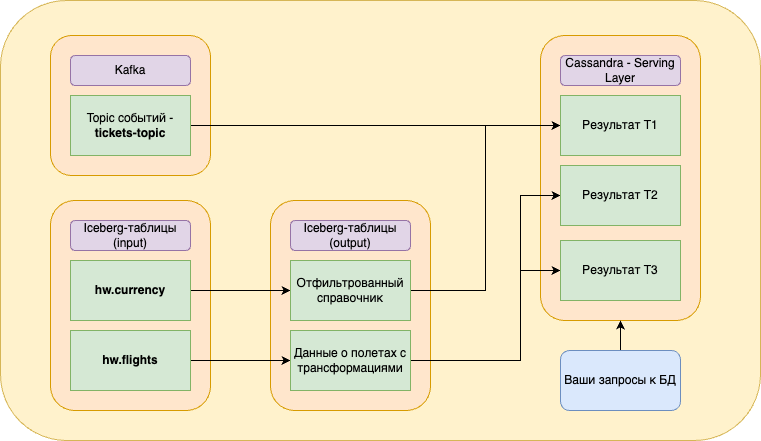

In [2]:
from IPython.display import Image
Image(filename="hw3/schema2.png")

### Решение

#### 1. EDA

Посмотрим на структуру в топике kafka.

In [8]:
kafka_stream.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



In [100]:
batch_df = spark.read \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "dataops-hadoop-ext:9092") \
    .option("subscribe", topic) \
    .load()

batch_df.show()

+----+--------------------+-------------+---------+------+--------------------+-------------+
| key|               value|        topic|partition|offset|           timestamp|timestampType|
+----+--------------------+-------------+---------+------+--------------------+-------------+
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59054|2025-08-20 18:22:...|            0|
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59055|2025-08-20 18:23:...|            0|
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59056|2025-08-20 18:24:...|            0|
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59057|2025-08-20 18:25:...|            0|
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59058|2025-08-20 18:25:...|            0|
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59059|2025-08-20 18:25:...|            0|
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59060|2025-08-20 18:26:...|            0|
|null|[7B 22 75 75 69 6...|tickets-topic|        7| 59061|20

Теперь посмотрим на таблицу `flights`.

In [7]:
currency = spark.table("ice_hdfs.hw.currency")
flights = spark.table("ice_hdfs.hw.flights")

2025-08-29 12:31:01 WARN  hive.conf.HiveConf:4122 - HiveConf of name hive.metastore.warehouse.external.dir does not exist
2025-08-29 12:31:01 WARN  hive.conf.HiveConf:4122 - HiveConf of name hive.enforce.bucketing does not exist


In [28]:
flights.printSchema()

root
 |-- number: string (nullable = true)
 |-- departure: string (nullable = true)
 |-- arrival: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- capacity: string (nullable = true)
 |-- luggage_allowed: string (nullable = true)
 |-- meal_included: string (nullable = true)



In [30]:
flights.limit(10).show(truncate=False)

+------+------------+---------------------------+----------------+----------------+------------+---------------+--------+---------------+-------------+
|number|departure   |arrival                    |departure_time  |arrival_time    |manufacturer|model          |capacity|luggage_allowed|meal_included|
+------+------------+---------------------------+----------------+----------------+------------+---------------+--------+---------------+-------------+
|YH6818|к. Валдай   |с. Петропавловск-Камчатский|2025-06-03 06:59|2025-06-03 13:59|Embraer     |Embraer ERJ 140|189     |yes            |yes          |
|ZW7961|ст. Балашов |с. Тамбов                  |2024-08-18 02:47|2024-08-18 06:47|Airbus      |Airbus A310    |189     |yes            |yes          |
|SS8060|г. Слюдянка |клх Мытищи                 |2025-06-15 15:27|2025-06-16 03:27|Boeing      |Boeing 767     |173     |yes            |yes          |
|KP6396|п. Магадан  |клх Александров            |2025-02-11 12:06|2025-02-11 14:06|Airbu

Создадим колонки с временем полёта и идентификатором авиакомпании.

In [22]:
flight_times = (flights
    .withColumn("flight_hours",(unix_timestamp("arrival_time", "yyyy-MM-dd HH:mm") - unix_timestamp("departure_time", "yyyy-MM-dd HH:mm")) / 3600)
    .withColumn("airline", substring(col("number"), 1, 2))
)

In [36]:
flight_times.show(30, truncate=False)

+------+---------------------+---------------------------+----------------+----------------+------------+------------------------+--------+---------------+-------------+------------+-------+
|number|departure            |arrival                    |departure_time  |arrival_time    |manufacturer|model                   |capacity|luggage_allowed|meal_included|flight_hours|airline|
+------+---------------------+---------------------------+----------------+----------------+------------+------------------------+--------+---------------+-------------+------------+-------+
|YH6818|к. Валдай            |с. Петропавловск-Камчатский|2025-06-03 06:59|2025-06-03 13:59|Embraer     |Embraer ERJ 140         |189     |yes            |yes          |7.0         |YH     |
|ZW7961|ст. Балашов          |с. Тамбов                  |2024-08-18 02:47|2024-08-18 06:47|Airbus      |Airbus A310             |189     |yes            |yes          |4.0         |ZW     |
|SS8060|г. Слюдянка          |клх Мытищи     

Уже можно увидеть проблему: корректно время полёта рассчитать не получится, потому что похоже время отправления и время прибытия указываются по местному времени, а никакого смещения от UTC не указано.

Посмотрим на распределение количества полётов по авиакомпаниям.

In [40]:
avg_by_airline = (
    flight_times
    .groupBy("airline")
    .agg(F.count("*").alias("n_records"))
)

avg_by_airline.show(truncate=False)

+-------+---------+
|airline|n_records|
+-------+---------+
|ZW     |333198   |
|YH     |333575   |
|QS     |333315   |
|BD     |332820   |
|LQ     |332142   |
|QH     |332955   |
|WZ     |333318   |
|HO     |334064   |
|KP     |333032   |
|EN     |332380   |
|GJ     |333255   |
|SS     |334132   |
|AT     |333698   |
|PT     |334692   |
|UC     |333424   |
+-------+---------+



Все записи распределены равномерно, никаких перекосов нет.

Посмотрим на таблицу `currency`.

In [ ]:
currency.printSchema()

In [46]:
currecy_latest = currency.orderBy(F.desc("timestamp"))

currecy_latest.show(20, truncate=False)

+----------------+-------------+---------------+--------+------------+
|timestamp       |base_currency|target_currency|ratio   |partition_dt|
+----------------+-------------+---------------+--------+------------+
|2025-08-27 14:50|USD          |MYR            |4.39    |2025-08-27  |
|2025-08-27 14:50|USD          |HKD            |8.27    |2025-08-27  |
|2025-08-27 14:50|USD          |SGD            |1.37    |2025-08-27  |
|2025-08-27 14:50|USD          |GGP            |0.76    |2025-08-27  |
|2025-08-27 14:50|USD          |DZD            |128.78  |2025-08-27  |
|2025-08-27 14:50|USD          |MRO            |378.69  |2025-08-27  |
|2025-08-27 14:50|USD          |GTQ            |7.63    |2025-08-27  |
|2025-08-27 14:50|USD          |CUC            |1.09    |2025-08-27  |
|2025-08-27 14:50|USD          |EUR            |0.88    |2025-08-27  |
|2025-08-27 14:50|USD          |IDR            |16044.88|2025-08-27  |
|2025-08-27 14:50|USD          |GHS            |11.09   |2025-08-27  |
|2025-

In [49]:
currency.groupBy("partition_dt").count().orderBy(F.desc("partition_dt")).show()

+------------+-----+
|partition_dt|count|
+------------+-----+
|  2025-08-27| 3401|
|  2025-08-26| 5472|
|  2025-08-25| 5472|
|  2025-08-24| 5244|
|  2025-08-23| 5472|
|  2025-08-22| 5472|
|  2025-08-21| 5377|
|  2025-08-20| 5472|
|  2025-08-19| 5472|
|  2025-08-18| 5472|
|  2025-08-17| 5472|
|  2025-08-16| 5225|
|  2025-08-15| 5472|
|  2025-08-14| 5453|
|  2025-08-13| 5472|
|  2025-08-12| 5472|
|  2025-08-11| 5472|
|  2025-08-10| 5472|
|  2025-08-09| 5472|
|  2025-08-08| 5472|
+------------+-----+
only showing top 20 rows



Партицирование равномерное, что хорошо с точки хранения данных. Также благодаря разбиению на партиции по дате мы можем очень быстро найти актуальный для нас курс.

In [52]:
spark.sql("DESCRIBE EXTENDED ice_hdfs.hw.currency").show(40, truncate=False)

+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                                                  |comment|
+----------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+-------+
|timestamp                   |string                                                                                                                                     |       |
|base_currency               |string                                                                                                                                     |       |
|target_currency             |string                                                                     

In [53]:
spark.sql("DESCRIBE EXTENDED ice_hdfs.hw.flights").show(40, truncate=False)

+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|col_name                    |data_type                                                                                                                                          |comment|
+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------+-------+
|number                      |string                                                                                                                                             |       |
|departure                   |string                                                                                                                                             |       |
|arrival                     |string                             

Видим, что таблица `currency` хранится в формате orc, а таблица `flights` в формате parquet. Обе таблицы используют табличный формат iceberg.

Можно хранить даты в обеих таблицах в типе данных времени, а capacity во `flights` в `int`.

#### 2. Speed layer

Преобразуем бинарное значение в json, чтобы посмотреть на его структуру.

In [120]:
batch_df \
    .withColumn("json_value", F.col("value").cast("string")) \
    .orderBy(F.desc("timestamp")) \
    .select("json_value", "timestamp") \
    .show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+
|json_value                                                                                                                                           |timestamp              |
+-----------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------+
|{"uuid": "8652ff43-338c-4453-b0fa-1e910fbee3ce", "number": "ZS6791", "price": "76015", "currency_codes": "HKD", "transaction_timestamp": 1756473554} |2025-08-29 17:19:14.623|
|{"uuid": "70b8cd48-a1c6-42bf-a877-155a634a4cf8", "number": "ZS5020", "price": "80599", "currency_codes": "CLP", "transaction_timestamp": 1756473553} |2025-08-29 17:19:13.621|
|{"uuid": "a85c185f-5a02-488c-893a-599f071b6e36", "number": "BE5203", "price": "138096", "currency_codes": "CLP", "trans

Достаём из таблицы `currency` только самые актуальные данные по курсу валют. Таблица поделена на партиции и мы этим воспользуемся. Сначала считываем две последние партиции, чтобы уменьшить объём данных для поиска актуальных курсов. Далее группируем всё по `target_currency`и берём самые первые данные о курсе, находя максимальный `timestamp`.

In [101]:
currency_partitions = spark.table("ice_hdfs.hw.currency.partitions")
last_2_partitions_dates = currency_partitions.select(F.col("partition")["partition_dt"].alias("date")).orderBy(F.col("date").desc()).limit(2)
last_2_dates_currency = currency.join(broadcast(last_2_partitions_dates), F.col("partition_dt") == last_2_partitions_dates.date, "inner")

currency_latets = (last_2_dates_currency
    .groupBy("target_currency")
    .agg(F.max(F.struct(F.col("timestamp"), F.col("ratio"))).alias("latest_ratio"))
    .select(
        F.col("target_currency"),
        F.col("latest_ratio").getField("ratio").alias("ratio")
    )
)

2025-08-29 17:00:52 WARN  hive.conf.HiveConf:4122 - HiveConf of name hive.metastore.warehouse.external.dir does not exist
2025-08-29 17:00:52 WARN  hive.conf.HiveConf:4122 - HiveConf of name hive.enforce.bucketing does not exist


Прочитаем данные с потока kafka и распарсим данные в формате json. Также создадим отдельную колонку с идентификатором авиакомпании.

In [108]:
tickets = kafka_stream \
    .withColumn("json_value", F.col("value").cast("string")) \
    .select(
        F.get_json_object("json_value", "$.uuid").alias("uuid"),
        F.get_json_object("json_value", "$.number").alias("number"),
        F.get_json_object("json_value", "$.currency_codes").alias("currency_codes"),
        F.get_json_object("json_value", "$.price").alias("price").cast("double"),
        F.get_json_object("json_value", "$.transaction_timestamp").cast("long").alias("transaction_timestamp"),
        F.unix_timestamp("timestamp").alias("kafka_timestamp")
    ) \
    .withColumn("airline", F.substring(F.col("number"), 1, 2))

Теперь посчитаем отставание от покупки билета до появления записи в kafka и исключим те данные, у которых отставание больше, чем 1 день.

In [109]:
tickets_with_lag = tickets.withColumn("lag_days", F.floor((F.col("kafka_timestamp") - F.col("transaction_timestamp")) / (60 * 60 * 24)))

relevant_tickets = tickets_with_lag.filter(F.col("lag_days") == 0)

Теперь делаем join таблицы с билетами и таблицы с актуальными курсами валют и рассчитываем цену билетов в базовой валюте (USD$).

In [110]:
tickets_in_usd = relevant_tickets \
    .join(
        broadcast(currency_latets),
        F.col("currency_codes") == F.col("target_currency"),
        how="left"
    ) \
    .withColumn("price_in_usd", round(col("price") / col("ratio"), 2)) \
    .withColumn("transaction_timestamp", F.timestamp_seconds(F.col("transaction_timestamp"))) \
    .withColumn("kafka_timestamp", F.timestamp_seconds(F.col("kafka_timestamp")))

In [111]:
windowed = (tickets_in_usd
    .withWatermark("kafka_timestamp", "1 minute")
    .groupBy(
        F.window(F.col("kafka_timestamp"), "5 minutes"),
        F.col("airline")
    )
    .agg(F.round(F.sum("price_in_usd"), 2).alias("revenue_in_usd"))
    .select(
        "airline",
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "revenue_in_usd"
    )
)

In [133]:
windowed.explain()

== Physical Plan ==
*(10) HashAggregate(keys=[window#4286-T60000ms, airline#4199], functions=[sum(price_in_usd#4236)])
+- StateStoreSave [window#4286-T60000ms, airline#4199], state info [ checkpoint = <unknown>, runId = b07fe68c-66f7-43eb-80eb-5a176f306e51, opId = 0, ver = 0, numPartitions = 16], Append, 0, 2
   +- *(9) HashAggregate(keys=[window#4286-T60000ms, airline#4199], functions=[merge_sum(price_in_usd#4236)])
      +- StateStoreRestore [window#4286-T60000ms, airline#4199], state info [ checkpoint = <unknown>, runId = b07fe68c-66f7-43eb-80eb-5a176f306e51, opId = 0, ver = 0, numPartitions = 16], 2
         +- *(8) HashAggregate(keys=[window#4286-T60000ms, airline#4199], functions=[merge_sum(price_in_usd#4236)])
            +- Exchange hashpartitioning(window#4286-T60000ms, airline#4199, 16), ENSURE_REQUIREMENTS, [plan_id=3333]
               +- *(7) HashAggregate(keys=[window#4286-T60000ms, airline#4199], functions=[partial_sum(price_in_usd#4236)])
                  +- *(7) Proje

Создадим keyspace в Cassandra.

In [100]:
keyspace_create_query = """
CREATE KEYSPACE IF NOT EXISTS hw_cassandra_ks_user20
WITH replication = {
  'class': 'SimpleStrategy', 
  'replication_factor': '1'
}"""

session.execute(keyspace_create_query)

In [101]:
session.set_keyspace('hw_cassandra_ks_user20')

Построим модель для таблицы с выручкой каждой авиакомпании в нашем keyspace. Ключ `((airline), window_start)` с партицированием по авиакомпании. Упорядочиваем строки внутри партиции по убыванию `window_start`.

In [102]:
revenue_table_query = """
CREATE TABLE IF NOT EXISTS hw_cassandra_ks_user20.airline_revenue (
  airline text,
  window_start timestamp,
  window_end timestamp,
  revenue_in_usd double,
  PRIMARY KEY ((airline), window_start)
) WITH CLUSTERING ORDER BY (window_start DESC);
"""

session.execute(revenue_table_query)

В режиме `append` пишем строку для окна ровно один раз — в момент финализации 5-ти минутного окна.

Настраиваем `checkpointLocation` чтобы избежать дублирования после рестарта.

Благодаря `stateful aggregation` Spark поддерживает внутреннее состояние и обновляет его инкрементально каждые 30 секунд. Также благодаря `watermark` Spark будет 1 минуту ждать «поздние» события перед тем, как считать окно окончательно закрытым и очистить состояние.

In [134]:
stream_query = (windowed
    .writeStream
    .outputMode("append")
    .format("org.apache.spark.sql.cassandra")
    .option("keyspace", "hw_cassandra_ks_user20")
    .option("table", "airline_revenue")
    .option("checkpointLocation", "student_user20/checkpoints")
    .trigger(processingTime="30 seconds")
    .start()
)

In [137]:
df = spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .option("keyspace", "hw_cassandra_ks_user20") \
    .option("table", "airline_revenue") \
    .load()

df.orderBy(F.desc("window_start")).show(10)

+-------+-------------------+--------------+-------------------+
|airline|       window_start|revenue_in_usd|         window_end|
+-------+-------------------+--------------+-------------------+
|     XU|2025-08-29 17:15:00|      139404.6|2025-08-29 17:20:00|
|     WD|2025-08-29 17:15:00|     535523.04|2025-08-29 17:20:00|
|     SR|2025-08-29 17:15:00|     475730.41|2025-08-29 17:20:00|
|     VU|2025-08-29 17:15:00|     108181.31|2025-08-29 17:20:00|
|     BE|2025-08-29 17:15:00|     351856.97|2025-08-29 17:20:00|
|     ZS|2025-08-29 17:15:00|     284110.98|2025-08-29 17:20:00|
|     VM|2025-08-29 17:15:00|      481337.1|2025-08-29 17:20:00|
|     XZ|2025-08-29 17:15:00|      85588.12|2025-08-29 17:20:00|
|     IX|2025-08-29 17:15:00|     657233.09|2025-08-29 17:20:00|
|     QX|2025-08-29 17:15:00|      99477.75|2025-08-29 17:20:00|
+-------+-------------------+--------------+-------------------+
only showing top 10 rows



Выведем топ-10 строк в ячейку с помощью запроса к БД через `cqlsh`.

In [167]:
! cqlsh dataops-hadoop-ext -e "SELECT * FROM hw_cassandra_ks_user20.airline_revenue LIMIT 10"


 airline | window_start                    | revenue_in_usd | window_end
---------+---------------------------------+----------------+---------------------------------
      QX | 2025-08-29 00:30:00.000000+0000 |      5.829e+05 | 2025-08-29 00:35:00.000000+0000
      QX | 2025-08-29 00:25:00.000000+0000 |       24116.28 | 2025-08-29 00:30:00.000000+0000
      QX | 2025-08-29 00:20:00.000000+0000 |     2.9277e+05 | 2025-08-29 00:25:00.000000+0000
      QX | 2025-08-29 00:15:00.000000+0000 |     3.1726e+05 | 2025-08-29 00:20:00.000000+0000
      QX | 2025-08-29 00:10:00.000000+0000 |     1.0074e+06 | 2025-08-29 00:15:00.000000+0000
      QX | 2025-08-29 00:05:00.000000+0000 |     4.6036e+05 | 2025-08-29 00:10:00.000000+0000
      BE | 2025-08-29 00:30:00.000000+0000 |     6.4227e+05 | 2025-08-29 00:35:00.000000+0000
      BE | 2025-08-29 00:25:00.000000+0000 |     3.4152e+05 | 2025-08-29 00:30:00.000000+0000
      BE | 2025-08-29 00:20:00.000000+0000 |     4.1172e+05 | 2025-08-29 00:25:

#### 3. Batch layer

Формируем списки с городами отправления и прибытия, чтобы посчитать их количество.

In [ ]:
departure_cities = flights.select('departure').distinct()
arrival_cities = flights.select('arrival').distinct()

In [ ]:
print(f"Количество городов отправления: {departure_cities.count()}")
print(f"Количество городов прибытия: {arrival_cities.count()}")

Теперь составим списки городов отправления и прибытия по авиакомпаниям.

In [ ]:
departure_routes = flights.select(
    F.substring(F.col("number"), 1, 2).alias("airline"),
    F.col("departure").alias("city"),
    F.lit("departure").alias("direction")
).distinct()

arrival_routes = flights.select(
    F.substring(F.col("number"), 1, 2).alias("airline"),
    F.col("arrival").alias("city"),
    F.lit("arrival").alias("direction")
).distinct()

route_list = departure_routes.union(arrival_routes)

print(f"Количество маршрутов по всем авиакомпаниям: {route_list.count()}")

Количество маршрутов по всем авиакомпаниям: 1500


In [ ]:
route_list.explain()

== Physical Plan ==
Union
:- *(2) HashAggregate(keys=[airline#118, city#119, departure#166], functions=[])
:  +- Exchange hashpartitioning(airline#118, city#119, departure#166, 16), ENSURE_REQUIREMENTS, [plan_id=328]
:     +- *(1) HashAggregate(keys=[airline#118, city#119, departure AS departure#166], functions=[])
:        +- *(1) Project [substring(number#31, 1, 2) AS airline#118, departure#32 AS city#119]
:           +- *(1) ColumnarToRow
:              +- BatchScan[number#31, departure#32] ice_hdfs.hw.flights (branch=null) [filters=, groupedBy=] RuntimeFilters: []
+- *(4) HashAggregate(keys=[airline#124, city#125, arrival#167], functions=[])
   +- Exchange hashpartitioning(airline#124, city#125, arrival#167, 16), ENSURE_REQUIREMENTS, [plan_id=337]
      +- *(3) HashAggregate(keys=[airline#124, city#125, arrival AS arrival#167], functions=[])
         +- *(3) Project [substring(number#130, 1, 2) AS airline#124, arrival#132 AS city#125]
            +- *(3) ColumnarToRow
             

In [13]:
route_list.show(10, False)

+-------+----------------------+---------+
|airline|city                  |direction|
+-------+----------------------+---------+
|EN     |с. Токма              |departure|
|HO     |клх Агата             |departure|
|BD     |п. Кедровый           |departure|
|UC     |г. Красногорск (Моск.)|departure|
|AT     |г. Надым              |departure|
|PT     |ст. Гудермес          |departure|
|WZ     |г. Йошкар-Ола         |departure|
|KP     |д. Галич              |departure|
|AT     |к. Сусуман            |departure|
|EN     |клх Елец              |departure|
+-------+----------------------+---------+
only showing top 10 rows



Строим отчёт по авиапарку компаний за 2024-2025 год. Группируем рейсы по году, идентификатору авиакомпании и модели самолёта. Далее считаем необходимые метрики.

In [18]:
airline_fleet_report = (flights
    .withColumn("airline", substring(col("number"), 1, 2))
    .withColumn("year", F.year("departure_time"))
    .groupBy("year", "airline", "model")
    .agg(
        F.count("*").alias("aircraft_number"),
        round(F.sum("capacity"), 2).alias("total_capacity"),
        round(F.avg("capacity"), 2).alias("average_capacity")
    )
)

In [19]:
airline_fleet_report.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[year#344, airline#332, model#37], functions=[count(1), sum(cast(capacity#38 as double)), avg(cast(capacity#38 as double))])
+- Exchange hashpartitioning(year#344, airline#332, model#37, 16), ENSURE_REQUIREMENTS, [plan_id=629]
   +- *(1) HashAggregate(keys=[year#344, airline#332, model#37], functions=[partial_count(1), partial_sum(cast(capacity#38 as double)), partial_avg(cast(capacity#38 as double))])
      +- *(1) Project [model#37, capacity#38, substring(number#31, 1, 2) AS airline#332, year(cast(departure_time#34 as date)) AS year#344]
         +- *(1) ColumnarToRow
            +- BatchScan[number#31, departure_time#34, model#37, capacity#38] ice_hdfs.hw.flights (branch=null) [filters=, groupedBy=] RuntimeFilters: []




In [21]:
airline_fleet_report.show(10, False)

+----+-------+---------------------+---------------+--------------+----------------+
|year|airline|model                |aircraft_number|total_capacity|average_capacity|
+----+-------+---------------------+---------------+--------------+----------------+
|2024|YH     |Boeing 787 Dreamliner|4493           |802138.0      |178.53          |
|2025|UC     |Airbus A220          |3848           |689268.0      |179.12          |
|2025|GJ     |Boeing 777           |3844           |688828.0      |179.2           |
|2025|EN     |Embraer E190-E2      |3813           |684351.0      |179.48          |
|2024|SS     |Airbus A300          |4658           |833587.0      |178.96          |
|2024|LQ     |Embraer ERJ 145      |4453           |798805.0      |179.39          |
|2024|AT     |Bombardier CRJ100    |4393           |788589.0      |179.51          |
|2025|ZW     |Embraer ERJ 145      |3733           |670575.0      |179.63          |
|2024|SS     |Embraer ERJ 135      |4486           |807021.0     

Возьмём расширенную таблицу `flight_times` с уже посчитанными на EDA временем полёта и идентификатором авиакомпании. Как мы выяснили во время EDA, время отправления и время прибытия указываются по местному времени, а значит мы не сможем корректно рассчитать время полёта. Предлагаю не обращать внимания на разные часовые пояса и допустить, что время полёта корректно. Во время подсчёта среднего времени полёта мы не будем учитывать все отрицательные значения времени полёта.

In [ ]:
top5_lowest_avg_flight_time_airlines = (flight_times
    .select("airline", "flight_hours")
    .filter(F.col("flight_hours") > 0)
    .groupBy("airline")
    .agg(round(F.avg("flight_hours"), 2).alias("avg_flight_hours"))
    .orderBy("avg_flight_hours")
    .limit(5)
)

In [27]:
top5_lowest_avg_flight_time_airlines.explain()

== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[avg_flight_hours#521 ASC NULLS FIRST], output=[airline#472,avg_flight_hours#521])
+- *(2) HashAggregate(keys=[airline#472], functions=[avg(flight_hours#460)])
   +- Exchange hashpartitioning(airline#472, 16), ENSURE_REQUIREMENTS, [plan_id=869]
      +- *(1) HashAggregate(keys=[airline#472], functions=[partial_avg(flight_hours#460)])
         +- *(1) Project [substring(number#31, 1, 2) AS airline#472, (cast((unix_timestamp(arrival_time#35, yyyy-MM-dd HH:mm, Some(Europe/Moscow), false) - unix_timestamp(departure_time#34, yyyy-MM-dd HH:mm, Some(Europe/Moscow), false)) as double) / 3600.0) AS flight_hours#460]
            +- *(1) Filter ((cast((unix_timestamp(arrival_time#35, yyyy-MM-dd HH:mm, Some(Europe/Moscow), false) - unix_timestamp(departure_time#34, yyyy-MM-dd HH:mm, Some(Europe/Moscow), false)) as double) / 3600.0) > 0.0)
               +- *(1) ColumnarToRow
                  +- BatchScan[number#31, departure_time#34, arri

In [28]:
top5_lowest_avg_flight_time_airlines.show(10, False)

+-------+----------------+
|airline|avg_flight_hours|
+-------+----------------+
|QS     |10.97           |
|GJ     |10.98           |
|EN     |10.99           |
|SS     |10.99           |
|QH     |10.99           |
+-------+----------------+



Рассчитаем, сколько пассажиров авиакомпании могут перевезти за конкретный квартал в разрезе каждой компании.

In [53]:
quarter_capacity = (flights
    .withColumn("airline", substring(col("number"), 1, 2))
    .select("airline", "departure_time", "capacity")
    .withColumn("year", F.year("departure_time"))
    .withColumn("quarter", F.quarter("departure_time"))
    .groupBy("year", "quarter", "airline")
    .agg(F.sum("capacity").cast("integer").alias("total_capacity"))
)

Посчитаем изменение в процентах от квартала к кварталу используя оконную функцию.

In [69]:
w = Window.partitionBy("airline").orderBy("year", "quarter")

quarter_report = (quarter_capacity
    .withColumn("prev_total_capacity", F.lag("total_capacity").over(w))
    .withColumn("capacity_changing",
        F.when(F.col("prev_total_capacity").isNull() | (F.col("prev_total_capacity") == 0), F.lit(None))
            .otherwise(round((F.col("total_capacity") - F.col("prev_total_capacity")) / F.col("prev_total_capacity") * 100.0, 2))
    )
    .orderBy(F.desc("total_capacity"))
)

In [70]:
quarter_report.explain()

== Physical Plan ==
*(5) Sort [total_capacity#1119 DESC NULLS LAST], true, 0
+- Exchange rangepartitioning(total_capacity#1119 DESC NULLS LAST, 16), ENSURE_REQUIREMENTS, [plan_id=2177]
   +- *(4) Project [year#1102, quarter#1107, airline#1087, total_capacity#1119, prev_total_capacity#1306, CASE WHEN (isnull(prev_total_capacity#1306) OR (prev_total_capacity#1306 = 0)) THEN null ELSE round(((cast((total_capacity#1119 - prev_total_capacity#1306) as double) / cast(prev_total_capacity#1306 as double)) * 100.0), 2) END AS capacity_changing#1312]
      +- Window [lag(total_capacity#1119, -1, null) windowspecdefinition(airline#1087, year#1102 ASC NULLS FIRST, quarter#1107 ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS prev_total_capacity#1306], [airline#1087], [year#1102 ASC NULLS FIRST, quarter#1107 ASC NULLS FIRST]
         +- *(3) Sort [airline#1087 ASC NULLS FIRST, year#1102 ASC NULLS FIRST, quarter#1107 ASC NULLS FIRST], false, 0
            +- Exchange hashpartitioning(airli

In [71]:
quarter_report.show(10, False)

+----+-------+-------+--------------+-------------------+-----------------+
|year|quarter|airline|total_capacity|prev_total_capacity|capacity_changing|
+----+-------+-------+--------------+-------------------+-----------------+
|2024|3      |AT     |14054112      |4539142            |209.62           |
|2024|3      |KP     |14019801      |4581646            |206.0            |
|2024|4      |YH     |14003499      |13948425           |0.39             |
|2024|3      |UC     |14001201      |4552601            |207.54           |
|2024|3      |PT     |14000275      |4643795            |201.48           |
|2024|4      |QS     |13997165      |13952029           |0.32             |
|2024|4      |AT     |13992421      |14054112           |-0.44            |
|2024|4      |HO     |13991705      |13989036           |0.02             |
|2024|3      |HO     |13989036      |4572273            |205.95           |
|2024|3      |LQ     |13982783      |4545003            |207.65           |
+----+------

Сохраним все итоговые таблицы.

In [40]:
route_list.write.mode("overwrite").saveAsTable("ice_hdfs.student_user20.route_list")
airline_fleet_report.write.mode("overwrite").saveAsTable("ice_hdfs.student_user20.airline_fleet_report")
top5_lowest_avg_flight_time_airlines.write.mode("overwrite").saveAsTable("ice_hdfs.student_user20.top5_lowest_avg_flight_time_airlines")
quarter_report.write.mode("overwrite").saveAsTable("ice_hdfs.student_user20.quarter_report")

2025-08-29 15:33:57 WARN  hive.conf.HiveConf:4122 - HiveConf of name hive.metastore.warehouse.external.dir does not exist
2025-08-29 15:33:57 WARN  hive.conf.HiveConf:4122 - HiveConf of name hive.enforce.bucketing does not exist


#### 4. Serving layer

Создаём модель таблицы для списка маршрутов полёта.

In [44]:
session.execute(f"""
CREATE TABLE IF NOT EXISTS hw_cassandra_ks_user20.airline_itinerary (
    airline text,
    city text,
    direction text,
    PRIMARY KEY ((airline), city, direction)
)
""")

Создаём модель таблицы для количества перевезённых пассажиров за каждый квартал в разрезе каждой авиакомпании.

In [ ]:
session.execute(f"""
CREATE TABLE IF NOT EXISTS hw_cassandra_ks_user20.airline_quarterly_capacity (
  airline text,
  year int,
  quarter int,
  total_capacity int,
  capacity_changing double,
  PRIMARY KEY ((airline), year, quarter)
) WITH CLUSTERING ORDER BY (year DESC, quarter DESC)
""")

Запишем обе таблицы в Cassandra и проверим, прошла ли транзакция успешно. 

In [47]:
route_list = spark.table("ice_hdfs.student_user20.route_list")

route_list.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="airline_itinerary", keyspace="hw_cassandra_ks_user20") \
    .mode("append") \
    .save()

spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="airline_itinerary", keyspace="hw_cassandra_ks_user20") \
    .load() \
    .show(5, False)

+-------+---------------+---------+
|airline|city           |direction|
+-------+---------------+---------+
|QH     |г. Богучар     |arrival  |
|QH     |г. Богучар     |departure|
|QH     |г. Дудинка     |arrival  |
|QH     |г. Дудинка     |departure|
|QH     |г. Малая Вишера|arrival  |
+-------+---------------+---------+
only showing top 5 rows



In [73]:
quarter_report = spark.table("ice_hdfs.student_user20.quarter_report")

quarter_report_for_write = quarter_report.select("airline", "year", "quarter", "total_capacity", "capacity_changing")

quarter_report_for_write.write \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="airline_quarterly_capacity", keyspace="hw_cassandra_ks_user20") \
    .mode("append") \
    .save()

spark.read \
    .format("org.apache.spark.sql.cassandra") \
    .options(table="airline_quarterly_capacity", keyspace="hw_cassandra_ks_user20") \
    .load() \
    .show(5, False)

+-------+----+-------+-----------------+--------------+
|airline|year|quarter|capacity_changing|total_capacity|
+-------+----+-------+-----------------+--------------+
|PT     |2025|2      |-0.61            |13679956      |
|PT     |2025|1      |-1.41            |13764049      |
|PT     |2024|4      |-0.29            |13960234      |
|PT     |2024|3      |201.48           |14000275      |
|PT     |2024|2      |null             |4643795       |
+-------+----+-------+-----------------+--------------+
only showing top 5 rows



Выполним запрос, отвечающий на вопрос: `Сможет ли конкретная авиакомпания отправить меня в конкретный город?`

In [88]:
airline = "LQ"
city = "г. Анапа"

query = session.execute(
    """
    SELECT direction
    FROM hw_cassandra_ks_user20.airline_itinerary
    WHERE airline = %s AND city = %s
    LIMIT 1
    """,
    (airline, city)
).one()

if query:
    print(f"Авиакомпания {airline} организовывает рейсы в {city} по направлению {query.direction}")
else:
    print(f"Авиакомпания {airline} не организовывает рейсы в {city}")

Авиакомпания LQ организовывает рейсы в г. Анапа по направлению arrival


Выполним запрос, отвечающий на вопрос: `Сможет ли конкретная авиакомпания перевезти N пассажиров на основе данных за последний доступный отчётный квартальный период?`

In [ ]:
airline = "UC"
passengers_number = 8392105

query = session.execute(
    """
    SELECT total_capacity
    FROM hw_cassandra_ks_user20.airline_quarterly_capacity
    WHERE airline = %s
    ORDER BY year DESC, quarter DESC
    LIMIT 1
    """,
    (airline,)
).one()

if query.total_capacity >= passengers_number:
    print(f"Да, авиакомпания {airline} сможет перевезти {passengers_number} пассажиров на основе последних данных")
else:
    print(f"Нет, авиакомпания {airline} не сможет перевезти {passengers_number} пассажиров на основе последних данных")

Да, авиакомпания UC сможет перевезти 8392105 пассажиров на основе последних данных


Выполним запрос, отвечающий на вопрос: `Какая текущая выручка у конкретной компании за 2024 год?`

In [117]:
airline = "SS"

query = session.execute(
    """
    SELECT SUM(revenue_in_usd) as total_revenue
    FROM hw_cassandra_ks_user20.airline_revenue 
    WHERE airline = %s
    AND window_start >= '2024-01-01' 
    AND window_start < '2025-01-01'
    """,
    (airline,)
).one()

if query and query.total_revenue:
    print(f"Выручка авиакомпании {airline} за 2024 год составила {query.total_revenue:,.2f}$")
else:
    print(f"Нет данных о выручке авиакомпании {airline} за 2024 год")

Нет данных о выручке авиакомпании SS за 2024 год
